# Double DQN Agent

## Imports

In [1]:
import numpy as np

import gym

import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Embedding, Reshape
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import random
from collections import deque
import time

## Model

In [2]:
class Double_DQN_Agent:
    
    def __init__(self, env, optimizer, batch_size, memory_buffer_size=1000000):
        # general info
        self.state_size = env.observation_space.shape[0] # number of factors in the state; e.g: velocity, position, etc
        self.action_size = env.action_space.n
        self.optimizer = optimizer
        self.batch_size = batch_size
        
        # allow large replay exp space
        self.replay_exp = deque(maxlen=memory_buffer_size)
        
        self.gamma = 0.99
        self.epsilon = 1.0 # initialize with high exploration, which will decay later
        
        # Build Policy Network
        self.policy_network = Sequential()
        self.policy_network.add(Dense(128, input_dim = self.state_size, activation = "relu"))
        self.policy_network.add(Dense(128 , activation = "relu"))
        self.policy_network.add(Dense(self.action_size, activation = "linear"))
        self.policy_network.compile(loss = "mse", optimizer = self.optimizer)
        
        
        # Build Target Network
        self.target_network = Sequential()
        self.target_network.add(Dense(128, input_dim = self.state_size, activation = "relu"))
        self.target_network.add(Dense(128 , activation = "relu"))
        self.target_network.add(Dense(self.action_size, activation = "linear"))
        self.target_network.compile(loss = "mse", optimizer = self.optimizer)
        
        self.update_target_network()
        
    
    # add new experience to the replay exp
    def memorize_experience(self, state, action, reward, next_state, done):
        self.replay_exp.append((state, action, reward, next_state, done))
    
    def update_target_network(self):
        return self.target_network.set_weights(self.policy_network.get_weights())
    
    def choose_action(self, state):
        if np.random.uniform(0.0, 1.0) < self.epsilon: # exploration
            action = np.random.choice(self.action_size)
        else:
            state = np.reshape(state, [1, state_size])
            qhat = self.policy_network.predict(state) # output Q(s,a) for all a of current state
            action = np.argmax(qhat[0]) # because the output is m * n, so we need to consider the dimension [0]
            
        return action
     
    # update params in NN
    def learn_from_memory(self):
        # take a mini-batch from replay experience
        cur_batch_size = min(len(self.replay_exp), self.batch_size)
        mini_batch = random.sample(self.replay_exp, cur_batch_size)
        
        # batch data
        sampled_states = np.ndarray(shape = (cur_batch_size, self.state_size)) # replace 128 with cur_batch_size
        sampled_actions = np.ndarray(shape = (cur_batch_size, 1))
        sampled_rewards = np.ndarray(shape = (cur_batch_size, 1))
        sampled_next_states = np.ndarray(shape = (cur_batch_size, self.state_size))
        sampled_dones = np.ndarray(shape = (cur_batch_size, 1))

        temp=0
        for exp in mini_batch:
            sampled_states[temp] = exp[0]
            sampled_actions[temp] = exp[1]
            sampled_rewards[temp] = exp[2]
            sampled_next_states[temp] = exp[3]
            sampled_dones[temp] = exp[4]
            temp += 1
        
         
        sampled_qhat_next = self.target_network.predict(sampled_next_states)
        
        # set all Q values terminal states to 0
        sampled_qhat_next = sampled_qhat_next * (np.ones(shape = sampled_dones.shape) - sampled_dones)
        # choose max action for each state
        sampled_qhat_next = np.max(sampled_qhat_next, axis=1)
        
        sampled_qhat = self.policy_network.predict(sampled_states)
        
        for i in range(cur_batch_size):
            a = sampled_actions[i,0]
            sampled_qhat[i,int(a)] = sampled_rewards[i] + self.gamma * sampled_qhat_next[i]
            
        q_target = sampled_qhat
            
        self.policy_network.fit(sampled_states, q_target, epochs = 1, verbose = 0)
        

## Training

In [3]:
import timeit
start = timeit.default_timer()        


env = gym.make("LunarLander-v2")
optimizer = Adam(learning_rate = 0.0001)
agent = Double_DQN_Agent(env, optimizer, batch_size = 64)
state_size = env.observation_space.shape[0]

# load existing model
#agent.policy_network.set_weights(tf.keras.models.load_model('./ddqn-Model1.h5').get_weights())

timestep=0
rewards = []
aver_reward = []
aver = deque(maxlen=100)
max_episodes = 1000

for episode in range(max_episodes):
    state = env.reset()
    total_reward = 0
    done = False
    
    while not done:
        action = agent.choose_action(state)
        next_state, reward, done, info = env.step(action)
        
        #env.render()

        total_reward += reward
        
        agent.memorize_experience(state, action, reward, next_state, done)
        agent.learn_from_memory()
        
        state = next_state
        timestep += 1
        
        
    aver.append(total_reward)   
    current_average_reward = np.mean(aver)
    aver_reward.append(current_average_reward)
    
    rewards.append(total_reward)
        
    # update model_target after each episode
    agent.update_target_network()

    agent.epsilon = max(0.1, 0.995 * agent.epsilon) # decaying exploration
    print("Episode " +  str(episode) + " total rewards = " + str(total_reward) + " average rewards = " + str(current_average_reward))
    

stop = timeit.default_timer()
duration_in_minutes = (stop - start) #/ 60
print('Execution Time (in sec): ' + str(duration_in_minutes))     
                                                                                                                                                                                                                                                                                                                                            
agent.policy_network.save('./ddqn-Model1.h5')


Episode 0 total rewards = -232.36338335055294 average rewards = -232.36338335055294
Episode 1 total rewards = -89.08568810746117 average rewards = -160.72453572900704
Episode 2 total rewards = -218.92674833248844 average rewards = -180.12527326350084
Episode 3 total rewards = -260.55276546356185 average rewards = -200.2321463135161
Episode 4 total rewards = -88.68533810706464 average rewards = -177.92278467222582
Episode 5 total rewards = -412.36026818445407 average rewards = -216.99569859093052
Episode 6 total rewards = -151.87741696732087 average rewards = -207.69308693041486
Episode 7 total rewards = -99.80344961500306 average rewards = -194.20688226598838
Episode 8 total rewards = -227.4426195357301 average rewards = -197.89974196262634
Episode 9 total rewards = -140.749324095909 average rewards = -192.18470017595462
Episode 10 total rewards = -164.59795186496626 average rewards = -189.67681396586477
Episode 11 total rewards = -70.18327306421651 average rewards = -179.7190188907274

### Visualize Training

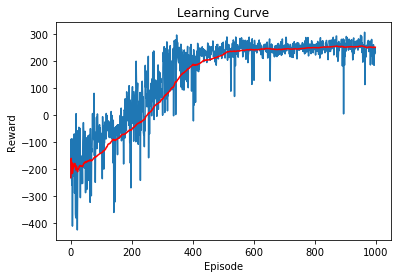

In [4]:
plt.title("Learning Curve")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.plot(rewards)

plt.xlabel("Episode")
plt.ylabel("Reward")
plt.plot(aver_reward, 'r')

### Save the model

In [11]:
import pickle
with open("double-dqn-rewards", "wb") as fp:
    pickle.dump(rewards, fp)
    
with open("double-dqn-avg-rewards", "wb") as fp:
    pickle.dump(aver_reward, fp)      

### Load the model

In [12]:
with open("double-dqn-rewards", "rb") as fp: 
    offline_rewards = pickle.load(fp)
    
with open("double-dqn-avg-rewards", "rb") as fp:
    offline_avg_rewards = pickle.load(fp)    


# Visualize Training

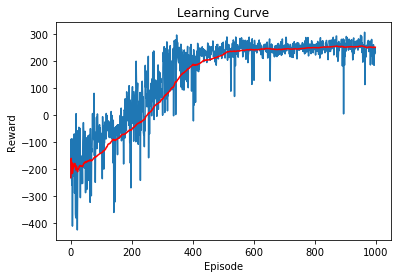

In [13]:
plt.title("Learning Curve")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.plot(offline_rewards)

plt.xlabel("Episode")
plt.ylabel("Reward")
plt.plot(offline_avg_rewards, 'r')